# Random Forest Prediction 


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix

In [2]:
# read in dataset with date column parsed
df = pd.read_csv('cleanedWeatherAUS.csv',
    parse_dates=['Date'],
    index_col='Date')

# drop samples with missing target values
df = df[df['RainTomorrow'].notna()]

# impute missing feature values
imputer = SimpleImputer(strategy='mean')
imputed_df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)


In [3]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(imputed_df.drop('RainTomorrow', axis=1), imputed_df['RainTomorrow'], test_size=0.2, random_state=42)


In [4]:
# Initialize the random forest classifier with hyperparameters
rfc = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Train the random forest classifier on the training data
rfc.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rfc.predict(X_test)


# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy Score:', accuracy)

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:', cm)


Accuracy Score: 0.8176818369311151
Confusion Matrix: [[21416   596     0]
 [ 4198  2219     3]
 [  454    53   153]]


Precision: 0.8146000343951012
Recall: 0.8176818369311151
F1 Score: 0.7879990680372982


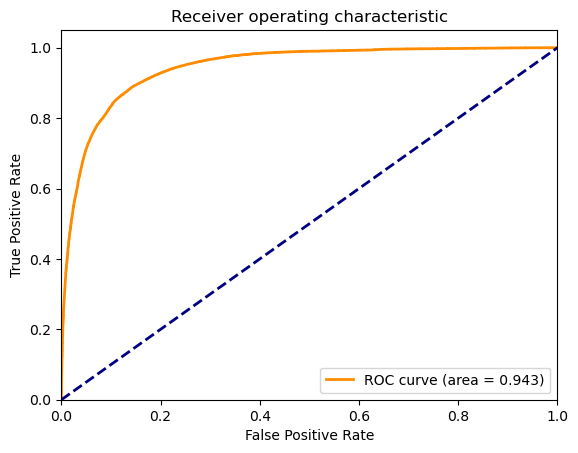

In [5]:
# Calculate the precision, recall, and F1 score
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

# Micro averaging for multiclass classification
from sklearn.metrics import roc_auc_score
#y_prob = rfc.predict_proba(X_test)
#auc = roc_auc_score(pd.get_dummies(y_test).values.ravel(), y_prob.ravel())
#print('AUC-ROC Score (micro):', auc)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_score = rfc.predict_proba(X_test)
fpr, tpr, _ = roc_curve(pd.get_dummies(y_test).values.ravel(), y_score.ravel())
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [6]:
# Feature selection and Hyperparameter Tuning 

from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Perform feature selection
sfm = SelectFromModel(rfc)
X_train_new = sfm.fit_transform(X_train, y_train)
X_test_new = sfm.transform(X_test)

# Print the selected features
selected_features = X_train.columns[sfm.get_support()]
print("Selected features:", list(selected_features))

# Perform hyperparameter tuning using grid search
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [10, 20, 30],
    "min_samples_split": [2, 4, 6],
}

grid_search = GridSearchCV(rfc, param_grid, cv=5)
grid_search.fit(X_train_new, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Evaluate the model on the test set
y_pred = grid_search.predict(X_test_new)
print(classification_report(y_test, y_pred))


Selected features: ['Rainfall', 'Sunshine', 'Humidity9am', 'Humidity3pm', 'Cloud3pm', 'RainToday']
Best hyperparameters: {'max_depth': 10, 'min_samples_split': 6, 'n_estimators': 300}
              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89     22012
         1.0       0.71      0.40      0.52      6420
         2.0       0.59      0.48      0.53       660

    accuracy                           0.82     29092
   macro avg       0.72      0.61      0.65     29092
weighted avg       0.81      0.82      0.80     29092

